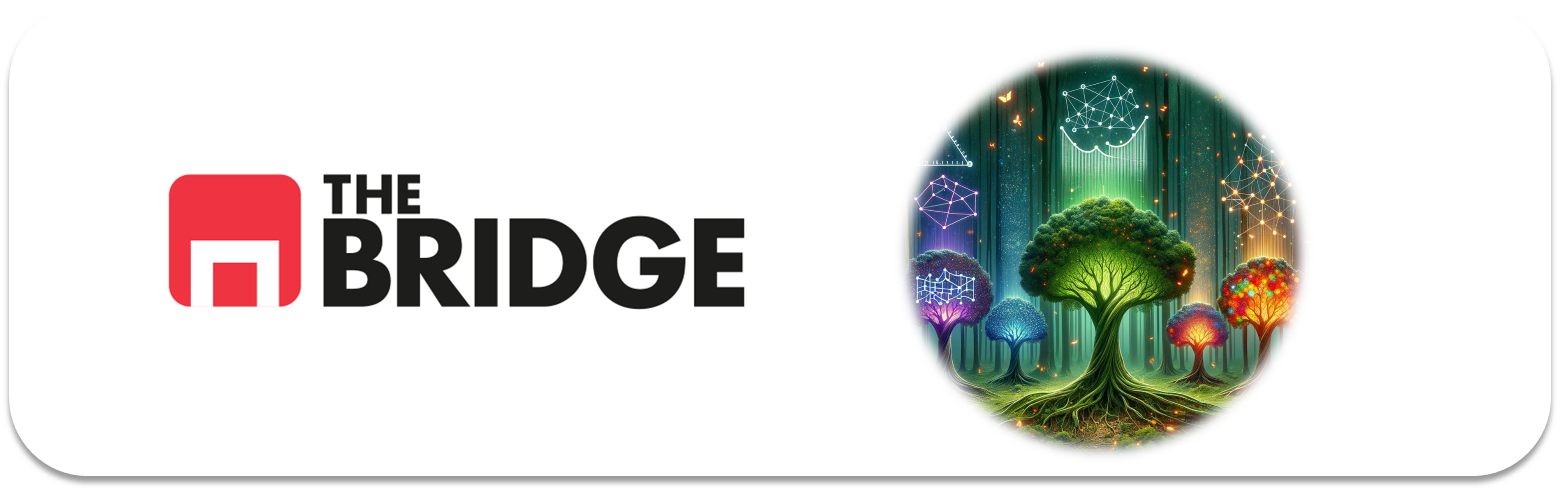

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt 
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# para que la salida de este notebook sea estable en todas las ejecuciones
np.random.seed(42)

# Pintar!
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [2]:
# damos por hecho que es un servicio de predictor (recall) y queremos que todos los que llamemos contraten

df = pd.read_csv("./data/bank-full.csv", sep=";")

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
df.y.value_counts(normalize=True)

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

In [5]:
# la única variable que no está explicada es "y", así que la tomaré como target, aunque está desbalanceada

target = "y"

# rename de la columna target para hacer más sencillo todo
df.rename(columns = {'y': 'target'}, inplace=True)

In [6]:
# Train / Test

train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

X_train = train_set.drop(columns= ['target'])
y_train = train_set['target']

X_test = test_set.drop(columns = ['target'])
y_test = test_set['target']

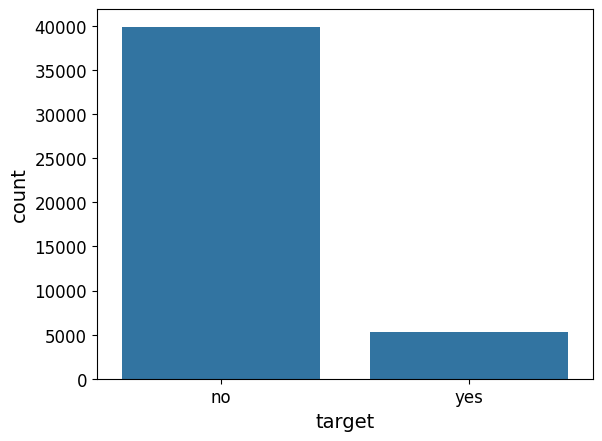

In [7]:
# MiniEDA

# Vemos la target de forma grafica
sns.countplot(data=df, x='target');

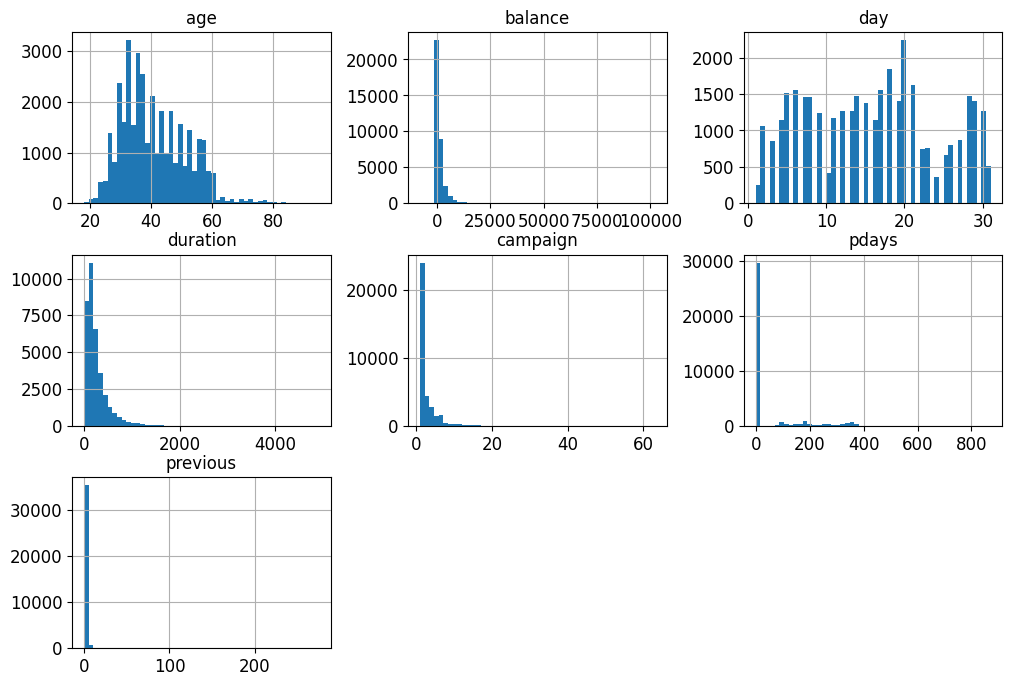

In [8]:
# generamos histogramas de una sola vez para las variables numéricas del dataset
train_set.hist(bins=50, figsize=(12, 8)) 
plt.show()

In [9]:
# Funcion para separar columnas y asi poder saber cuáles son las categoricas

def separar_columnas(df):
    # Inicializa listas para almacenar nombres de columnas categóricas y numéricas
    columnas_categoricas = []
    columnas_numericas = []

    # Itera sobre cada columna del DataFrame
    for columna in df.columns:
        # Si el tipo de datos de la columna es 'object', se considera categórica
        if df[columna].dtype == 'object':
            columnas_categoricas.append(columna)
        # Si el tipo de datos de la columna es numérico, se considera numérica
        else:
            columnas_numericas.append(columna)

    return columnas_categoricas, columnas_numericas

# Ejemplo de uso
# Suponiendo que tienes un DataFrame llamado 'df'
# Reemplaza 'df' con el nombre de tu DataFrame
columnas_categoricas, columnas_numericas = separar_columnas(df)
print("Columnas Categóricas:", columnas_categoricas)
print("Columnas Numéricas:", columnas_numericas)


Columnas Categóricas: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'target']
Columnas Numéricas: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


Como separar las categoricas
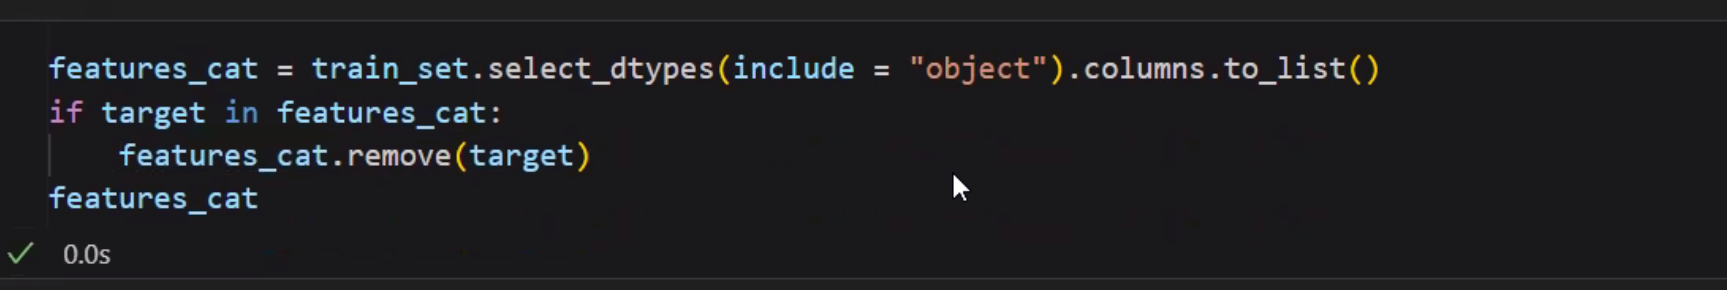

Como separar las numericas
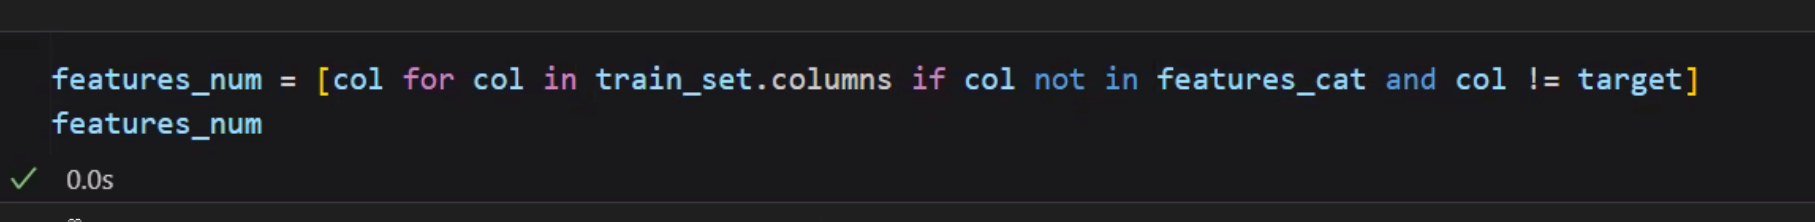

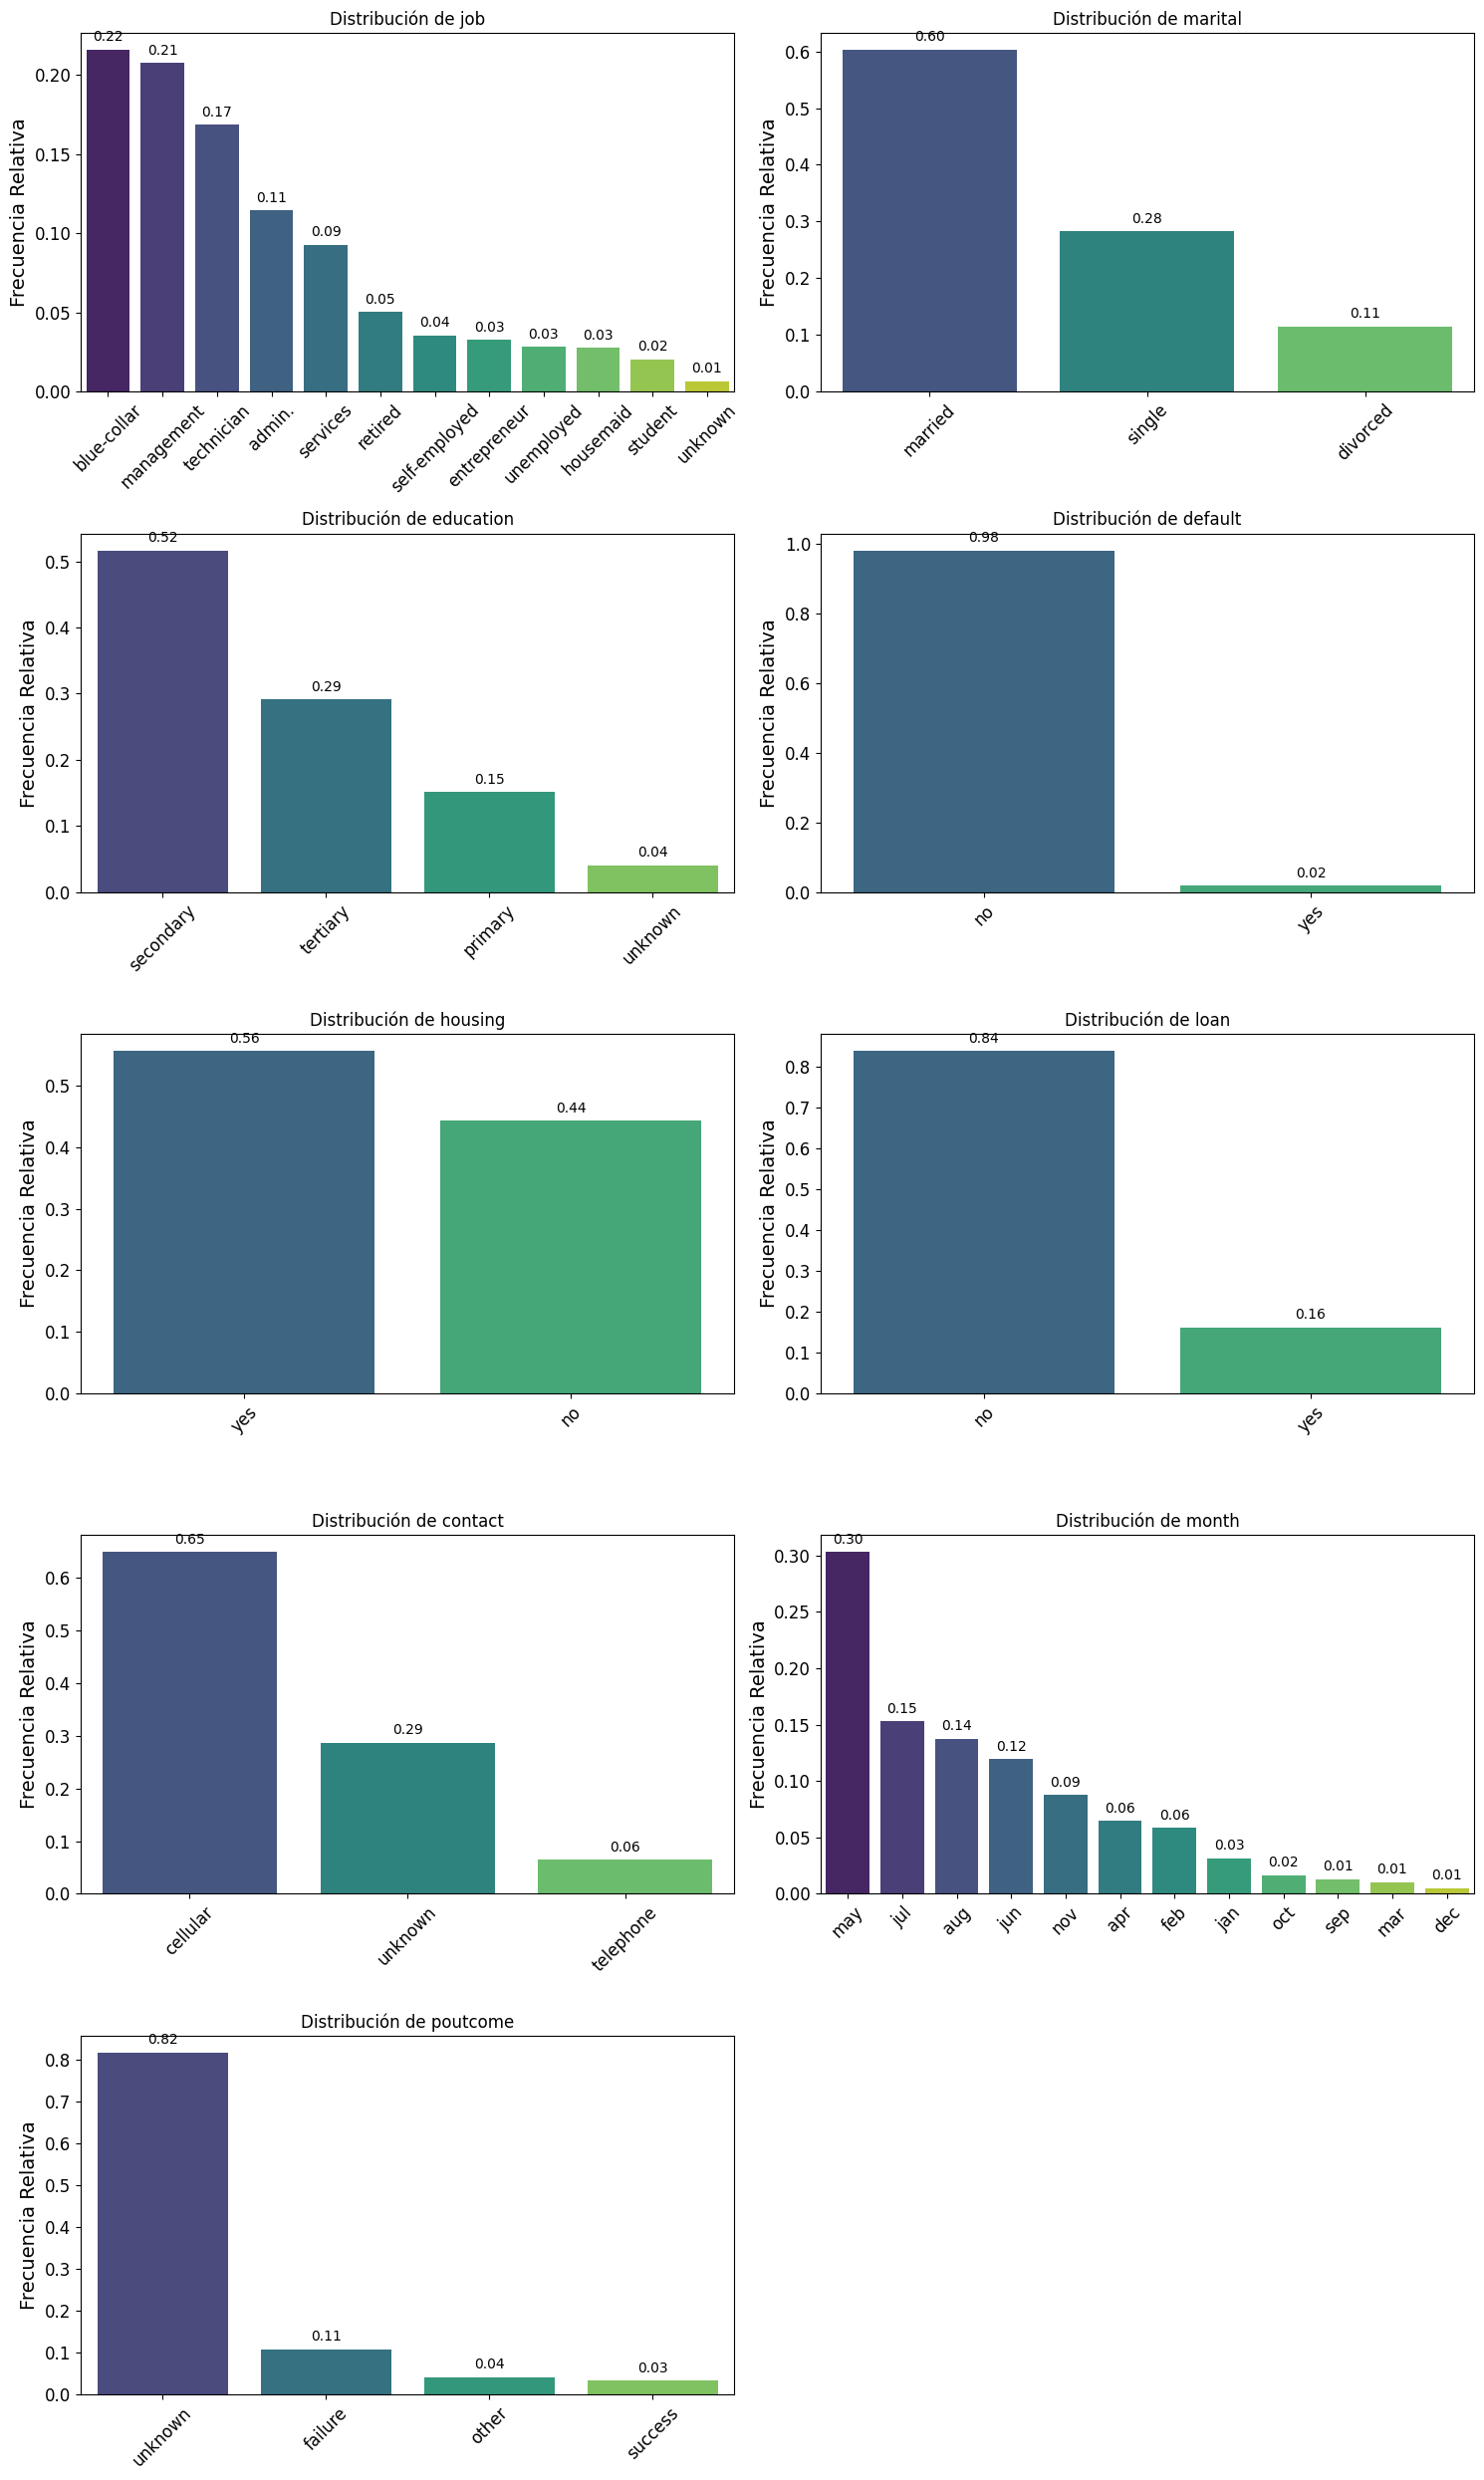

In [10]:
bt.pinta_distribucion_categoricas(train_set, ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'], relativa= True, mostrar_valores= True)

In [11]:
#conversion de variables categoricas a numericas con One Hot Encoding 
pd.get_dummies(train_set, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']).head()

,age,balance,day,duration,campaign,pdays,previous,target,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3344,41,849,15,72,1,-1,0,no,False,True,...,False,False,True,False,False,False,False,False,False,True
17965,49,1415,30,269,2,-1,0,no,False,False,...,False,False,False,False,False,False,False,False,False,True
18299,42,3842,31,130,4,-1,0,no,True,False,...,False,False,False,False,False,False,False,False,False,True
10221,37,-119,11,375,11,-1,0,no,False,False,...,True,False,False,False,False,False,False,False,False,True
32192,56,3498,15,264,2,-1,0,yes,False,True,...,False,False,False,False,False,False,False,False,False,True


In [12]:
pd.get_dummies(train_set, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'], dtype=int).head()

,age,balance,day,duration,campaign,pdays,previous,target,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3344,41,849,15,72,1,-1,0,no,0,1,...,0,0,1,0,0,0,0,0,0,1
17965,49,1415,30,269,2,-1,0,no,0,0,...,0,0,0,0,0,0,0,0,0,1
18299,42,3842,31,130,4,-1,0,no,1,0,...,0,0,0,0,0,0,0,0,0,1
10221,37,-119,11,375,11,-1,0,no,0,0,...,1,0,0,0,0,0,0,0,0,1
32192,56,3498,15,264,2,-1,0,yes,0,1,...,0,0,0,0,0,0,0,0,0,1


In [13]:
train_set_bck = train_set.copy()
train_set = pd.get_dummies(train_set, columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'], dtype=int)

In [14]:
test_set = pd.get_dummies(test_set, columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'], dtype=int)

In [15]:
features_num = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [16]:
# estadarizacion de numericas
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
resultado_min_max = pd.DataFrame(min_max_scaler.fit_transform(train_set[features_num]), columns= features_num)
resultado_min_max

,age,balance,day,duration,campaign,pdays,previous
0,-0.402597,-0.838977,-0.066667,-0.970720,-1.000000,-1.000000,-1.000000
1,-0.194805,-0.828700,0.933333,-0.890606,-0.967742,-1.000000,-1.000000
2,-0.376623,-0.784631,1.000000,-0.947133,-0.903226,-1.000000,-1.000000
3,-0.506494,-0.856554,-0.333333,-0.847499,-0.677419,-1.000000,-1.000000
4,-0.012987,-0.790878,-0.066667,-0.892639,-0.967742,-1.000000,-1.000000
...,...,...,...,...,...,...,...
36163,-0.324675,-0.835164,0.133333,-0.148841,-1.000000,-1.000000,-1.000000
36164,-0.870130,-0.845169,-0.533333,-0.914599,-1.000000,-0.786697,-0.992727
36165,-0.584416,-0.830480,-0.066667,-0.902806,-1.000000,-1.000000,-1.000000
36166,-0.610390,-0.851397,-0.600000,-0.954860,-1.000000,-1.000000,-1.000000


In [17]:
resultado_min_max.describe()

,age,balance,day,duration,campaign,pdays,previous
count,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,-0.404394,-0.829680,-0.012151,-0.895530,-0.943044,-0.905550,-0.995780
std,0.275802,0.054892,0.555057,0.104467,0.100651,0.229605,0.017241
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.610390,-0.853122,-0.533333,-0.958113,-1.000000,-1.000000,-1.000000
50%,-0.454545,-0.846277,0.000000,-0.926800,-0.967742,-1.000000,-1.000000
75%,-0.220779,-0.828446,0.333333,-0.870679,-0.935484,-1.000000,-1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


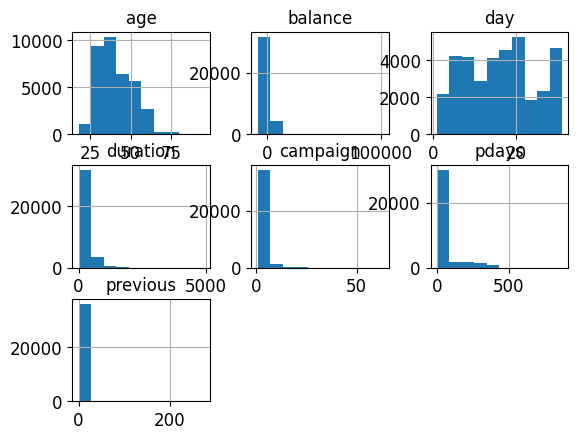

In [18]:
train_set[features_num].hist();

ValueError: supplied range of [-inf, 11.533972415813873] is not finite

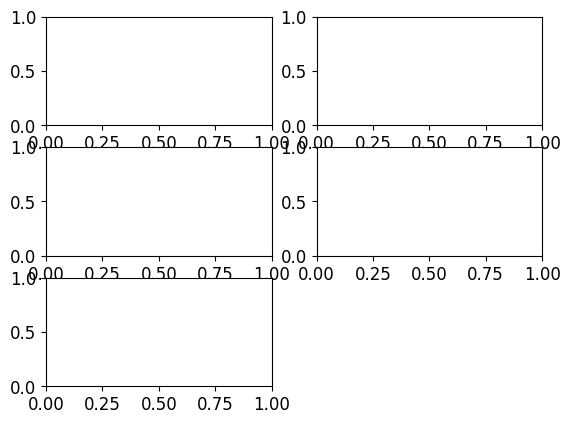

In [19]:
# aplico transformacion a las columnas con heavy tails
features_transform = ["balance","duration","campaign", "pdays", "previous"]

for feature in features_transform:
    train_set[feature] = train_set[feature].apply(np.log)

train_set[features_transform].hist()
plt.tight_layout();

In [20]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(train_set, test_set)

ValueError: could not convert string to float: 'no'

In [23]:
### train_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_absolute_percentage_error
pred_train = lin_reg.predict(train_set)

print("MAE:", median_absolute_error(test_set, pred_train))
print("RMSE:", mean_squared_error(test_set, pred_train, squared= False))
print("R^2:", lin_reg.score(train_set, test_set))

ValueError: could not convert string to float: 'no'

In [25]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(train_set, test_set)

ValueError: could not convert string to float: 'no'

A partir de ahí me empieza a fallar y no entiendo el motivo... 